In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## for our scripts:
# %aimport hmm
%autoreload 2
import hmm
## for plotting
%matplotlib inline

We will optimize the HMM model's hyper-parameters using Bayesian Optimization. 

Each parameter set contains a number of states, and some sequence window-length (in hours), and will train one HMM for every sensor (27 in all). The Window-length will be used to calculate the log-probability of a given sequence of predicted states, which is used for the unsupervised detection of low-probability states (sequences *containing* known anomlaies have been removed from the training sequence set). 




In [3]:
data_dir = os.path.join('.', 'data')

study = hmm.TurbineAnomalyHMM(data_dir, compress_window='4h')

domain = [{'name': 'anomaly_window', 'type': 'discrete', 'domain': range(8, 25)},
          {'name': 'n_states', 'type': 'discrete', 'domain': range(3, 8)}] 

reading h5...
done!


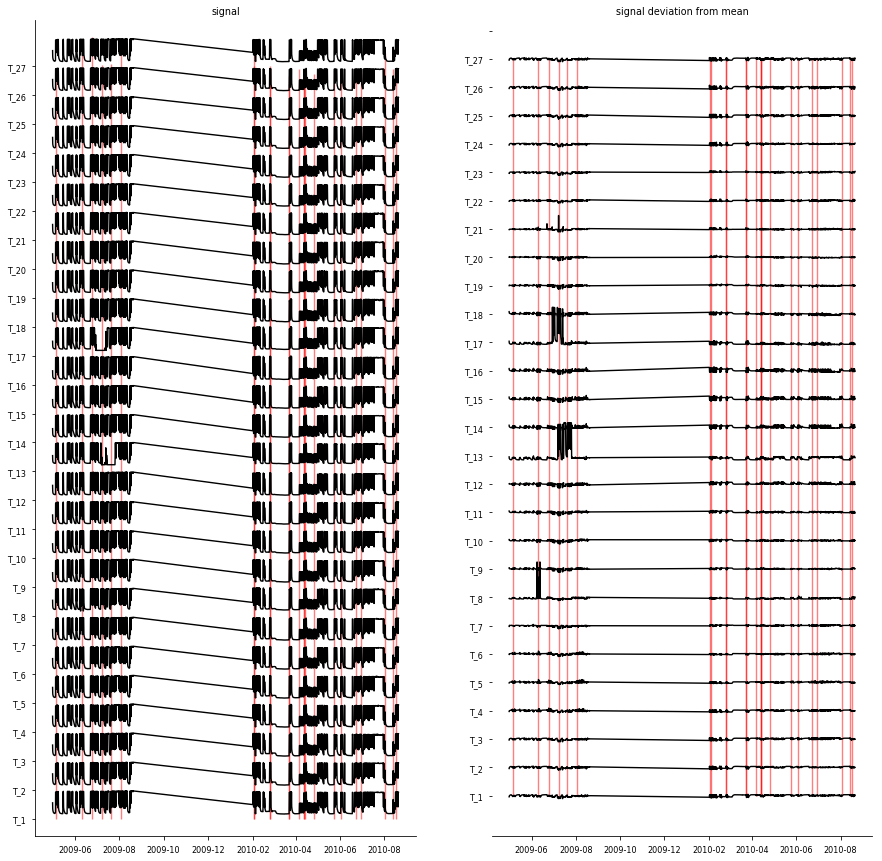

In [18]:
with sns.plotting_context(context='paper'):
    f, ax = plt.subplots(ncols=2, figsize=(15,15))
    study.signal_plot(ax=ax[0])
    sns.despine(ax=ax[0])
    study.signal_plot(ax=ax[1], kind='mean')
    sns.despine(ax=ax[1], left=True)
plt.savefig('./img/signal_plot.png')

`myBopt.plot_acquisition()`
![hi](./img/acq.png)

`myBopt.plot_convergence()`
![hi](./img/conv.png)

In [73]:
# mod = hmm.RollingHMM(dfr.T_3, 3, target, anomaly_window='13h')
# study.objective(np.array([[14.,3.]]))
from hmm import RollingHMM
import pickle
with open(os.path.join(data_dir, 'results', 'o{:.1f}w{}s{}_optHMM.pkl'.format(343.3,8,3)), 'rb') as f:
    opt_hmm = pickle.load(f)
    
# with open(os.path.join(data_dir, 'results', 'o{:.1f}w{}s{}_optHMM.pkl'.format(1363.5,48,10)), 'rb') as f:
#     opt_hmm = pickle.load(f)
    

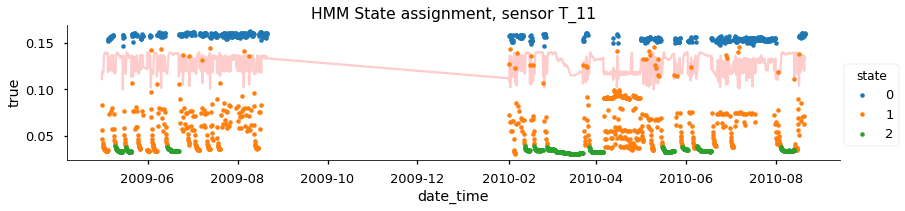

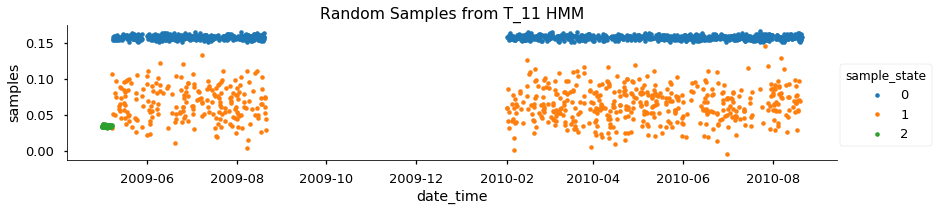

In [113]:
# plt.plot()
# plt.plot()
sensor='T_11'
n = study.dfr[sensor].shape[0]

pred = pd.DataFrame(data={'true' : study.dfr[sensor].iloc[:n],
                          'samples' : opt_hmm[sensor].model.sample(n)})

pred['state'] =  opt_hmm[sensor].model.predict(pred.true)
pred['sample_state'] = opt_hmm[sensor].model.predict(pred.samples)
pred.reset_index(inplace=True)
# plt.figure(figsize=(15,3))
# plt.plot(np.array(), '.')
# # plt.subplot(212)
# plt.ylim(0, .2)
# plt.figure(figsize=(15,3))
# plt.plot(study.dfr[sensor].iloc[:500].values, '.')
# plt.ylim(0, .2)
# pred
from sklearn.preprocessing import MinMaxScaler

fg = sns.FacetGrid(data=pred, hue='state', aspect=4.)
fg.map(plt.plot, 'date_time', 'true', marker='.', ls='').add_legend()
plt.gca().set_title(f"HMM State assignment, sensor {sensor}")
# ax2=plt.gca().twinx()
sense_like = MinMaxScaler(feature_range=(.1,.14)).fit_transform(opt_hmm[sensor].like().values.reshape(-1,1))
plt.plot(pred.date_time, sense_like, color='r', alpha=.2, zorder=0)
# sns.despine()
plt.savefig('./img/true_hmm_state.png')

fg2 = sns.FacetGrid(data=pred, hue='sample_state', aspect=4.)
fg2=fg2.map(plt.plot, 'date_time', 'samples', marker='.', ls='').add_legend()
plt.gca().set_title(f"Random Samples from {sensor} HMM")
plt.savefig('./img/samp_hmm_state')

In [20]:
res = {n:i.like() for n,i in opt_hmm.items()}
rmse = {n:i.rmse() for n,i in opt_hmm.items()}
study.target.shape[0]

1863

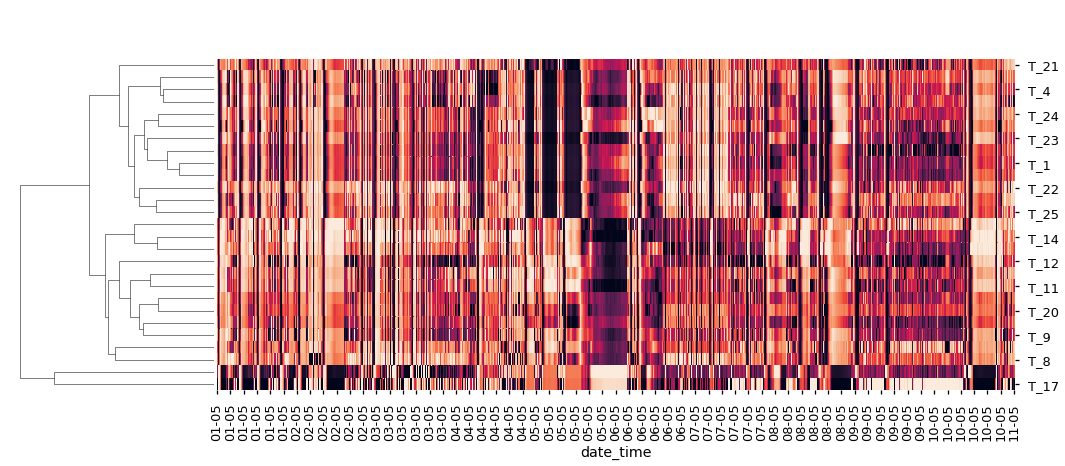

In [21]:
df = pd.DataFrame(data=res)
thres=max([i.unsupervised_anom().max() for n,i in opt_hmm.items()])
# sns.heatmap()
cg = sns.clustermap(df.T.dropna(),
              col_cluster=False, figsize=(18,7), standard_scale=1)
cg.ax_heatmap.set_xticklabels(df.reset_index().date_time.dt.strftime('%d-%m'));
cg.cax.set_visible(False)
# plt.figure()
# plt.scatter(study.target[study.target==1].index, study.target[study.target==1].shape[0]*[1], clip_on=False)
plt.savefig('./img/cluster_prob.png')

In [49]:
from scipy.stats import hmean
rmse_df = pd.Series(rmse).sort_values()
rmse_df, hmean(np.array(list(rmse.values())))

(T_11    141.206737
 T_7     166.292020
 T_1     170.194355
 T_24    179.055626
 T_4     189.364367
 T_14    206.742175
 T_9     362.545424
 T_13    363.690388
 T_27    364.463077
 T_2     366.565637
 T_10    373.727528
 T_26    380.093241
 T_19    380.542275
 T_16    384.489374
 T_23    384.504012
 T_3     394.401929
 T_5     395.868570
 T_15    440.045874
 T_25    518.984718
 T_12    568.110222
 T_8     610.209441
 T_20    709.279131
 T_6     761.412073
 T_21    826.339264
 T_22    881.972501
 T_18    900.543141
 T_17    990.008465
 dtype: float64, 343.34977603370447)

In [57]:
df.sum(axis=1)

date_time
2009-05-01 00:00:00     28.976907
2009-05-01 04:00:00     94.438408
2009-05-01 08:00:00     99.195111
2009-05-01 12:00:00     92.335972
2009-05-01 16:00:00     90.045802
2009-05-01 20:00:00     87.500420
2009-05-02 00:00:00     89.519895
2009-05-02 04:00:00    116.191657
2009-05-02 08:00:00    148.279223
2009-05-02 12:00:00    193.722267
2009-05-02 16:00:00    225.087089
2009-05-02 20:00:00    240.561763
2009-05-03 00:00:00    249.630895
2009-05-03 04:00:00    255.847096
2009-05-03 08:00:00    258.746317
2009-05-03 12:00:00    258.433873
2009-05-03 16:00:00    256.026075
2009-05-03 20:00:00    254.064272
2009-05-04 00:00:00    252.546192
2009-05-04 04:00:00    250.304378
2009-05-04 08:00:00    252.457526
2009-05-04 12:00:00    253.788425
2009-05-04 16:00:00    248.823213
2009-05-04 20:00:00    241.099973
2009-05-05 00:00:00    204.419964
2009-05-05 04:00:00    102.815825
2009-05-05 08:00:00    196.911992
2009-05-05 12:00:00    213.658053
2009-05-05 16:00:00    219.662451
2009

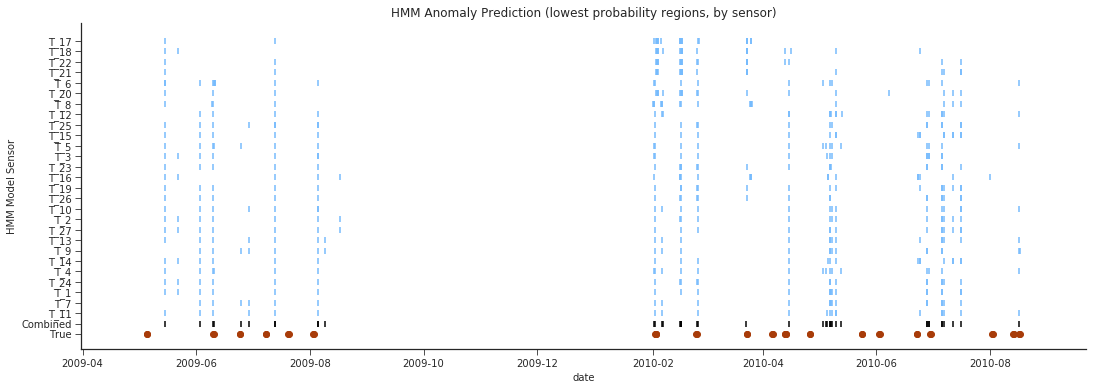

In [86]:
with sns.axes_style('ticks'):

    plt.figure(figsize=(18,6))
    ref = study.target[study.target.rolling('8h').max()==1]
    plt.scatter(ref.index, ref.shape[0]*[-2], clip_on=False, color='xkcd:rust')

    norm = df.sum(axis=1)
    min_idx = np.argpartition(norm, ref.shape[0])[:ref.shape[0]]
    plt.scatter(norm.iloc[min_idx].index, norm.iloc[min_idx].shape[0]*[-1], clip_on=False, color='k', marker='|')

    def get_target(hmm_ob, roll=False):
        target = pd.Series(index=hmm_ob.target.index, data=0)
        target[np.isin(hmm_ob.target.index, hmm_ob.unsupervised_anom().index)] = 1

        if roll:
            target = target.rolling('8h').max()
        return target

    for n, (name,err) in enumerate(rmse_df.iteritems()):
    #     t = opt_hmm[name].unsupervised_anom()
        t = get_target(opt_hmm[name], roll=False)

    #     print( t.shape[0]*[n])
        plt.scatter(t[t==1].index,t[t==1].shape[0]*[n], color='xkcd:sky blue', marker='|')

    plt.yticks(range(-2, 27, 1), ['True', 'Combined']+rmse_df.index.tolist());
    plt.ylabel('HMM Model Sensor')
    plt.xlabel('date')
    plt.title('HMM Anomaly Prediction (lowest probability regions, by sensor)')
    sns.despine()
plt.savefig('./img/unsupervised.png')

141.206737193


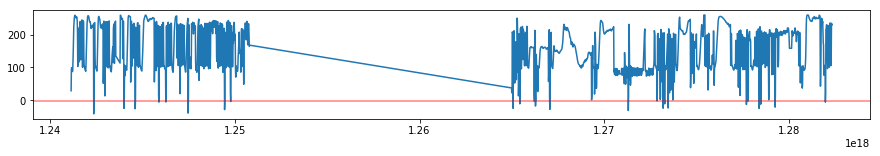

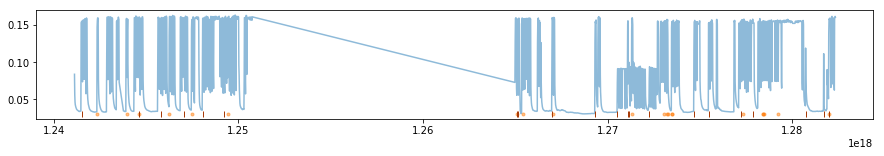

In [12]:
mod = opt_hmm['T_11']

lprob = mod.like()
lprob = df.sum(axis=1)
print(mod.rmse())
window_target = mod.target.rolling(mod.window).apply(np.max)

# thres=lprob.loc[mod.unsupervised_anom().index].max()
# thres=lprob.loc[mod.s.iloc[min_idx].index].max()
thres = mod.unsupervised_anom().max()
plt.figure(figsize=(15,2))
plt.plot(lprob)
plt.axhline(thres, color='r', alpha=.5)

plt.figure(figsize=(15,2))
plt.plot(mod.s, alpha=.5)

plt.plot((mod.s.min()*mod.s/mod.s)[mod.unsupervised_anom().index], '.', alpha=.5)
plt.plot(mod.s.min()*study.target[study.target==1], '|', markerfacecolor='none', color='xkcd:rust')
# plt.plot((mod.s.min()*mod.s/mod.s)[peakind], '.', alpha=.5)


In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import Normalizer
tscv = TimeSeriesSplit(n_splits=30)

# resX = pd.DataFrame(index=study.dfr.index, data=res['T_25'].T)
X = Normalizer().fit_transform(df.values)
y = study.target.values
# resX.shape
trials = np.empty((tscv.n_splits, 2))
for n, (train_idx, test_idx) in enumerate(tscv.split(X)):
    clf = SGDClassifier(class_weight='balanced', 
                        max_iter=1000, tol=1e-3)
    clf_old = SGDClassifier(class_weight='balanced', 
                            max_iter=1000, tol=1e-3)

#     clf = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
#     clf_old = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
    
    clf.fit(X[train_idx], y[train_idx])
    clf_old.fit(study.dfr.values[train_idx], y[train_idx])

    trials[n,0] = clf.score(X[test_idx], y[test_idx])
    trials[n,1] = clf_old.score(study.dfr.values[test_idx], y[test_idx])

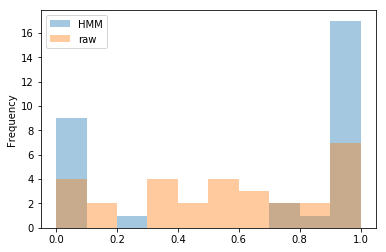

In [18]:
trialsdf = pd.DataFrame(trials, columns=['HMM', 'raw'])
trialsdf.plot(kind='hist', alpha=.4)

# DEPRECATED BELOW

date_time
2010-03-25 16:00:00   -0.441928
2010-02-25 16:00:00   -1.028308
2010-03-26 00:00:00   -1.032405
2010-02-15 20:00:00   -1.142375
2010-02-16 04:00:00   -1.738946
2010-02-16 16:00:00   -4.371987
2010-02-16 20:00:00   -5.401037
2010-02-18 20:00:00   -3.949740
2010-02-19 00:00:00   -0.550751
2010-03-25 20:00:00   -0.634746
2010-03-23 12:00:00   -1.297154
2010-02-06 00:00:00   -0.714440
2010-02-05 20:00:00   -1.995158
2010-02-03 20:00:00   -6.251667
2010-02-03 16:00:00   -2.473163
2010-02-03 08:00:00   -0.765727
2010-02-03 00:00:00   -0.586679
2010-03-23 16:00:00   -4.113924
2010-02-06 04:00:00    0.078284
2010-02-01 20:00:00    0.194030
2010-02-25 08:00:00    0.405402
Name: T_17, dtype: float64

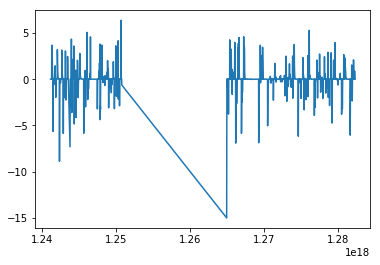

In [115]:

from scipy import signal
peakind = signal.find_peaks_cwt(-lprob, np.arange(1,20))
peakind, lprob.index.values[peakind], 
min_idx = np.argpartition(lprob.iloc[peakind], 20)[:20]

mod.s.iloc[min_idx]

plt.plot(lprob.rolling('48h').min().diff())
# plt.plot(lprob)
# plot()
# mod.target[mod.target==1]
# lprob.rolling('24h').min().drop_duplicates()
pd.Series.diff()
mod.unsupervised_anom()

In [4]:
if not os.path.isfile(os.path.join(data_dir, 'completeDB.h5')):
    print('reading in...')
    df = pd.concat([pd.read_csv(os.path.join(data_dir, 'data_6302.csv'), 
                                 index_col=0, parse_dates=True),
                    pd.read_csv(os.path.join(data_dir, 'data_7600.csv'), 
                                 index_col=0, parse_dates=True),
                    pd.read_csv(os.path.join(data_dir, 'data_7664.csv'), 
                                 index_col=0, parse_dates=True)])
    print('creating h5...')
    df.to_hdf(os.path.join(data_dir, 'completeDB.h5'))
    print('done!')
else:
    print('reading h5...')
    df = pd.read_hdf(os.path.join(data_dir, 'completeDB.h5'))
    print('done!')

reading h5...
done!


In [5]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_n = scale.fit_transform(df.loc[:,'T_1':'T_27'].values)
df_n = pd.DataFrame(data=df_n, index=df.index, columns=df.loc[:,'T_1':'T_27'].columns)

# dfo = df_n[df_n.abs()<3]
# dfo.index = pd.to_datetime(dfo.index)
compress_window = '3h'
dfr = df_n.resample(compress_window).median()
dfr = dfr[dfr.abs()<3]

dfr = dfr.dropna()

In [6]:


target = pd.Series(index=df_n.index, data=0)
target[np.isin(df_n.index,ref.date_time)] = 1

# dfr = dfo.resample(compress_window).mean()
target = target.resample(compress_window).max()
target = target[dfr.index]

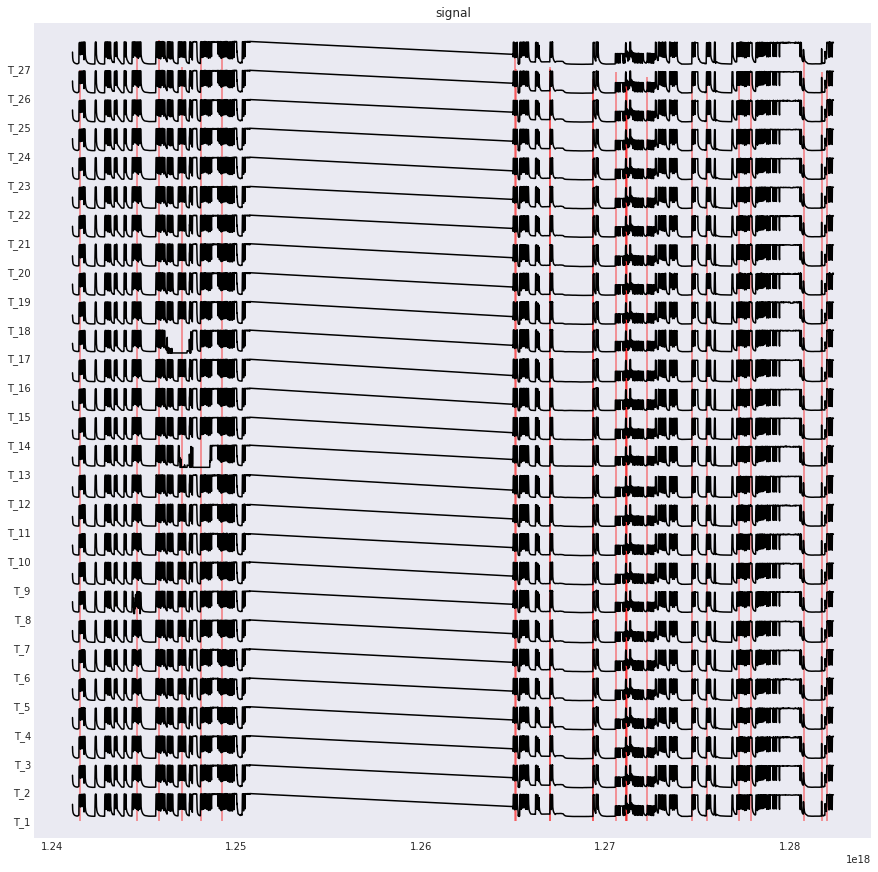

In [13]:
with sns.axes_style('dark'):
    plt.figure(figsize=(15,15))
    
#     for i, (name, sig) in enumerate(dfr.loc[:,'T_1':].iteritems()):
#         plt.plot(dfr.loc[:,'T_1':].mean(axis=1) - sig+0.1*i, 'k')
#     plt.vlines(ref[ref.file==6302].date_time.values, 0, 2.6, color='r', alpha=.5)
#     plt.title('signal deviation from mean')
#     plt.yticks(np.arange(0,2.8, .1),dfr.loc[:,'T_1':].columns )
    
    for i, (name, sig) in enumerate(dfr.iteritems()):
        plt.plot(sig+dfr.max().max()*i, 'k')
    plt.vlines(ref.date_time.values, 0, 27*dfr.max(), color='r', alpha=.5)
    plt.title('signal')
    plt.yticks(np.arange(0,27*dfr.max().max(), dfr.max().max()),dfr.columns )
    plt.ylim(-.1, 27*dfr.max().max()+.1)

In [21]:
mod = hmm.RollingHMM(dfr.T_3, 3, target, anomaly_window='6h')

In [23]:
mod.fit(n_jobs=3)

Parsing sub-sequences...
Parsed 4968 state sequences...
removed 4968 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
[1] Improvement: 1987.0969544074378	Time (s): 0.0303
[2] Improvement: 89.214340777693	Time (s): 0.02834
[3] Improvement: 34.440599830912106	Time (s): 0.03032
[4] Improvement: 16.091880366973783	Time (s): 0.03086
[5] Improvement: 7.507086428133334	Time (s): 0.02902
[6] Improvement: 3.6024055962989223	Time (s): 0.02846
[7] Improvement: 1.839077419568639	Time (s): 0.02744
[8] Improvement: 1.0023004125359876	Time (s): 0.03011
[9] Improvement: 0.5779437962919474	Time (s): 0.0304
[10] Improvement: 0.3488535405085713	Time (s): 0.03187
[11] Improvement: 0.21840893319858878	Time (s): 0.02689
[12] Improvement: 0.14079112653780612	Time (s): 0.02697
[13] Improvement: 0.0929115060444019	Time (s): 0.02996
[14] Improvement: 0.062491285119904205	Time (s): 0.02894
[15] Improvement: 0.04268888278238592	Time (s): 0.03821
[16] Improvement: 0.029536926513173967	Time (s)

{
    "class" : "HiddenMarkovModel",
    "name" : "None",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.03364355158200254,
                    0.005294434368431526
                ],
                "frozen" : false
            },
            "name" : "s0",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.1550295444964489,
                 

In [24]:
lprob = mod.like()

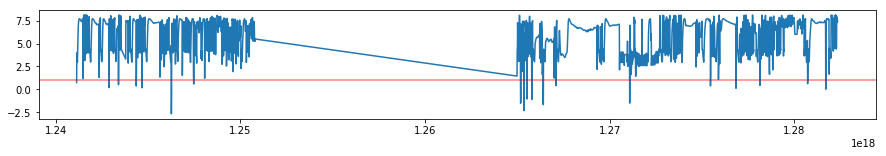

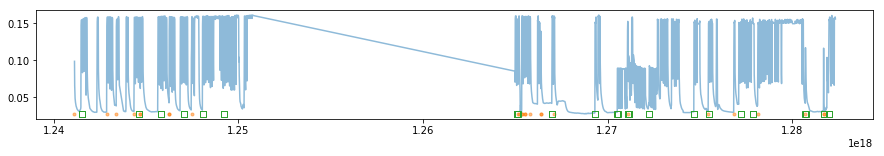

In [25]:
# lprob.plot()
# plt.vlines(ref[ref.file==6302].date_time.values, -10, 10, color='r', alpha=.5)
window_target = mod.target.rolling(mod.window).apply(np.max)

thres=1

plt.figure(figsize=(15,2))
plt.plot(lprob)
plt.axhline(thres, color='r', alpha=.5)

plt.figure(figsize=(15,2))
plt.plot(mod.s, alpha=.5)

plt.plot((mod.s.min()*mod.s/mod.s)[lprob<thres], '.', alpha=.5)
plt.plot(mod.s.min()*window_target[window_target==1], 's', markerfacecolor='none')
# plt.plot(mod.s[window_target==1], 's', markerfacecolor='none')

# dprob = pd.Series(np.gradient(lprob), index=lprob.index)
# plt.plot(dprob.iloc[10:])
# pd.to_datetime(ref[ref.file==6302].date_time)

In [47]:
experiment = {}

from tqdm import tqdm_notebook

for sensor, signal in tqdm_notebook(dfr.items()):
    experiment[sensor] = hmm.RollingHMM(signal, 3, target, anomaly_window='6h')
    experiment[sensor].fit(verbose=False, n_jobs=3)
    

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Training HMM...
Done!
Parsing sub-sequences...
Parsed 2484 state sequences...
removed 2484 NaN sequences...
Using 2441 Non-anomalous sequences;
 Trainin

In [57]:
res = {n:i.like() for n,i in experiment.items()}
rmse = {n:i.rmse() for n,i in experiment.items()}


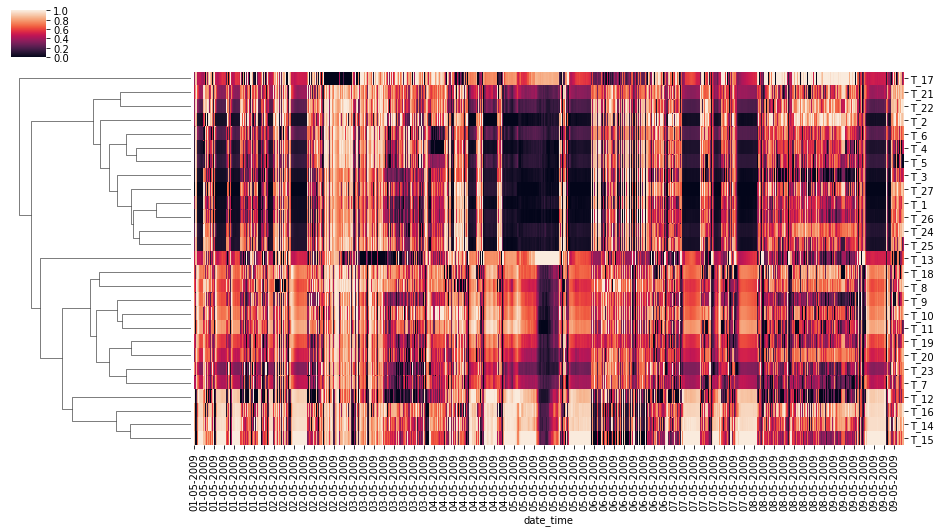

In [72]:
df = pd.DataFrame(data=res)
cg = sns.clustermap(df.T,
              col_cluster=False, standard_scale=1, figsize=(16,8))
cg.ax_heatmap.set_xticklabels(df.reset_index().date_time.dt.strftime('%d-%m-%Y'));

In [87]:
from scipy.stats import hmean
rmse_df = pd.Series(rmse).sort_values()
hmean(np.array(list(rmse.values())))
# mod.s.iloc[np.argpartition(mod.like(), 27)[:27]]
# int(mod.target.sum())

553.69011536722576

634.57911859554599

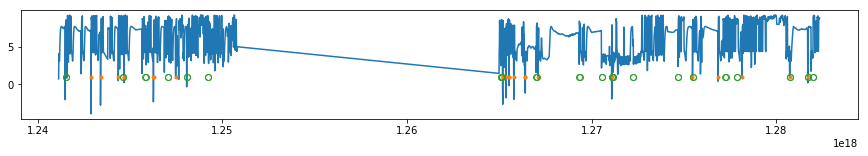

In [64]:
# norm = pd.Series( np.linalg.norm(res, axis=0), index=dfr.index)
plt.figure(figsize=(15,2))
plt.plot(norm)

from itertools import chain
import datetime as dt
norm = res['T_3']
min_idx = np.argpartition(norm, ref.shape[0])[:ref.shape[0]]
# min_idx = list(chain(*[np.argpartition(i, ref.shape[0])[:ref.shape[0]] for i in res]))
plt.plot((norm/norm).iloc[min_idx], '.')
plt.plot(window_target[window_target==1], 'o', markerfacecolor='none')
np.sqrt((np.array([i.item()*1e-13 for i in (norm.iloc[min_idx].sort_index().index.values -\
                          ref.sort_values(by='date_time').date_time.values)])**2).mean())

In [243]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=30)

resX = pd.DataFrame(index=study.dfr.index, data=res['T_25'].T)
# resX.shape
trials = np.empty((tscv.n_splits, 2))
for n, (train_idx, test_idx) in enumerate(tscv.split(resX)):
#     clf = SGDClassifier(class_weight='balanced', 
#                         max_iter=1000, tol=1e-3)
#     clf_old = SGDClassifier(class_weight='balanced', 
#                             max_iter=1000, tol=1e-3)
    clf = DecisionTreeClassifier()
    clf_old = DecisionTreeClassifier()
    
    clf.fit(resX.values[train_idx], window_target.values[train_idx])
    clf_old.fit(study.dfr.values[train_idx], window_target.values[train_idx])
    trials[n,0] = clf.score(resX.values[test_idx], study.target[test_idx])
    trials[n,1] = clf_old.score(study.dfr.values[test_idx], study.target[test_idx])
# n_trials = 100


# for i in range(n_trials):
#     clf = SGDClassifier(class_weight='balanced', 
#                         max_iter=1000, tol=1e-3)
#     clf_old = SGDClassifier(class_weight='balanced', 
#                             max_iter=1000, tol=1e-3)

#     clf.fit(resX.values[:2000], window_target.values[:2000])
#     clf_old.fit(dfr.values[:2000], window_target.values[:2000])
#     trials[i,0] = clf.score(resX.values[2000:], target[2000:])
#     trials[i,1] = clf_old.score(dfr.values[2000:], target[2000:])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [130]:
clf.score(resX.values[2000:], target[2000:]), clf_old.score(dfr.values[2000:], target[2000:])

(0.80165289256198347, 0.98966942148760328)

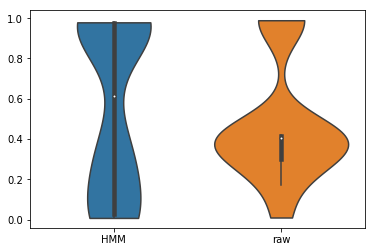

In [131]:
sns.violinplot(data=pd.DataFrame(trials, columns=['HMM', 'raw']), cut=0)

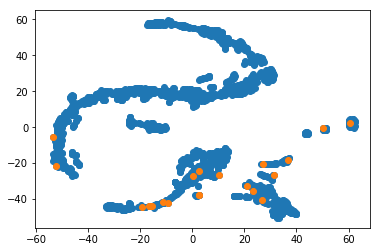

In [239]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE 
# pca = TruncatedSVD()
dfr_proj = TSNE().fit_transform(study.dfr)

plt.scatter(dfr_proj[:,0], dfr_proj[:,1])
plt.scatter(dfr_proj[study.target==1][:,0], dfr_proj[study.target==1][:,1])

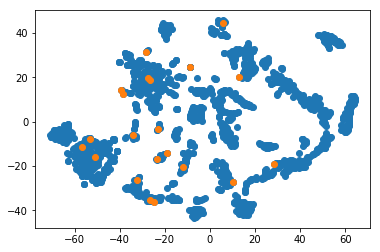

In [240]:
resX_proj = TSNE().fit_transform(X)
plt.scatter(resX_proj[:,0], resX_proj[:,1])
plt.scatter(resX_proj[study.target==1][:,0], resX_proj[study.target==1][:,1])